In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import phate

In [3]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [4]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

df = make_branch_cond(ne=2, repeats=20)


In [5]:
df

samples   e1        d1        d2
0          0 -1.0 -0.034889  0.054968
1          0 -1.0  0.151002  0.029287
2          0 -1.0  0.163355 -0.059603
3          0 -1.0  0.164923 -0.072056
4          1 -1.0  0.288280 -0.067361
..       ...  ...       ...       ...
795        3  1.0  0.932206  0.523483
796        4  1.0  0.930819  0.788406
797        4  1.0  1.034536  0.757093
798        4  1.0  0.839130  0.880604
799        4  1.0  0.925176  1.218131

[800 rows x 4 columns]

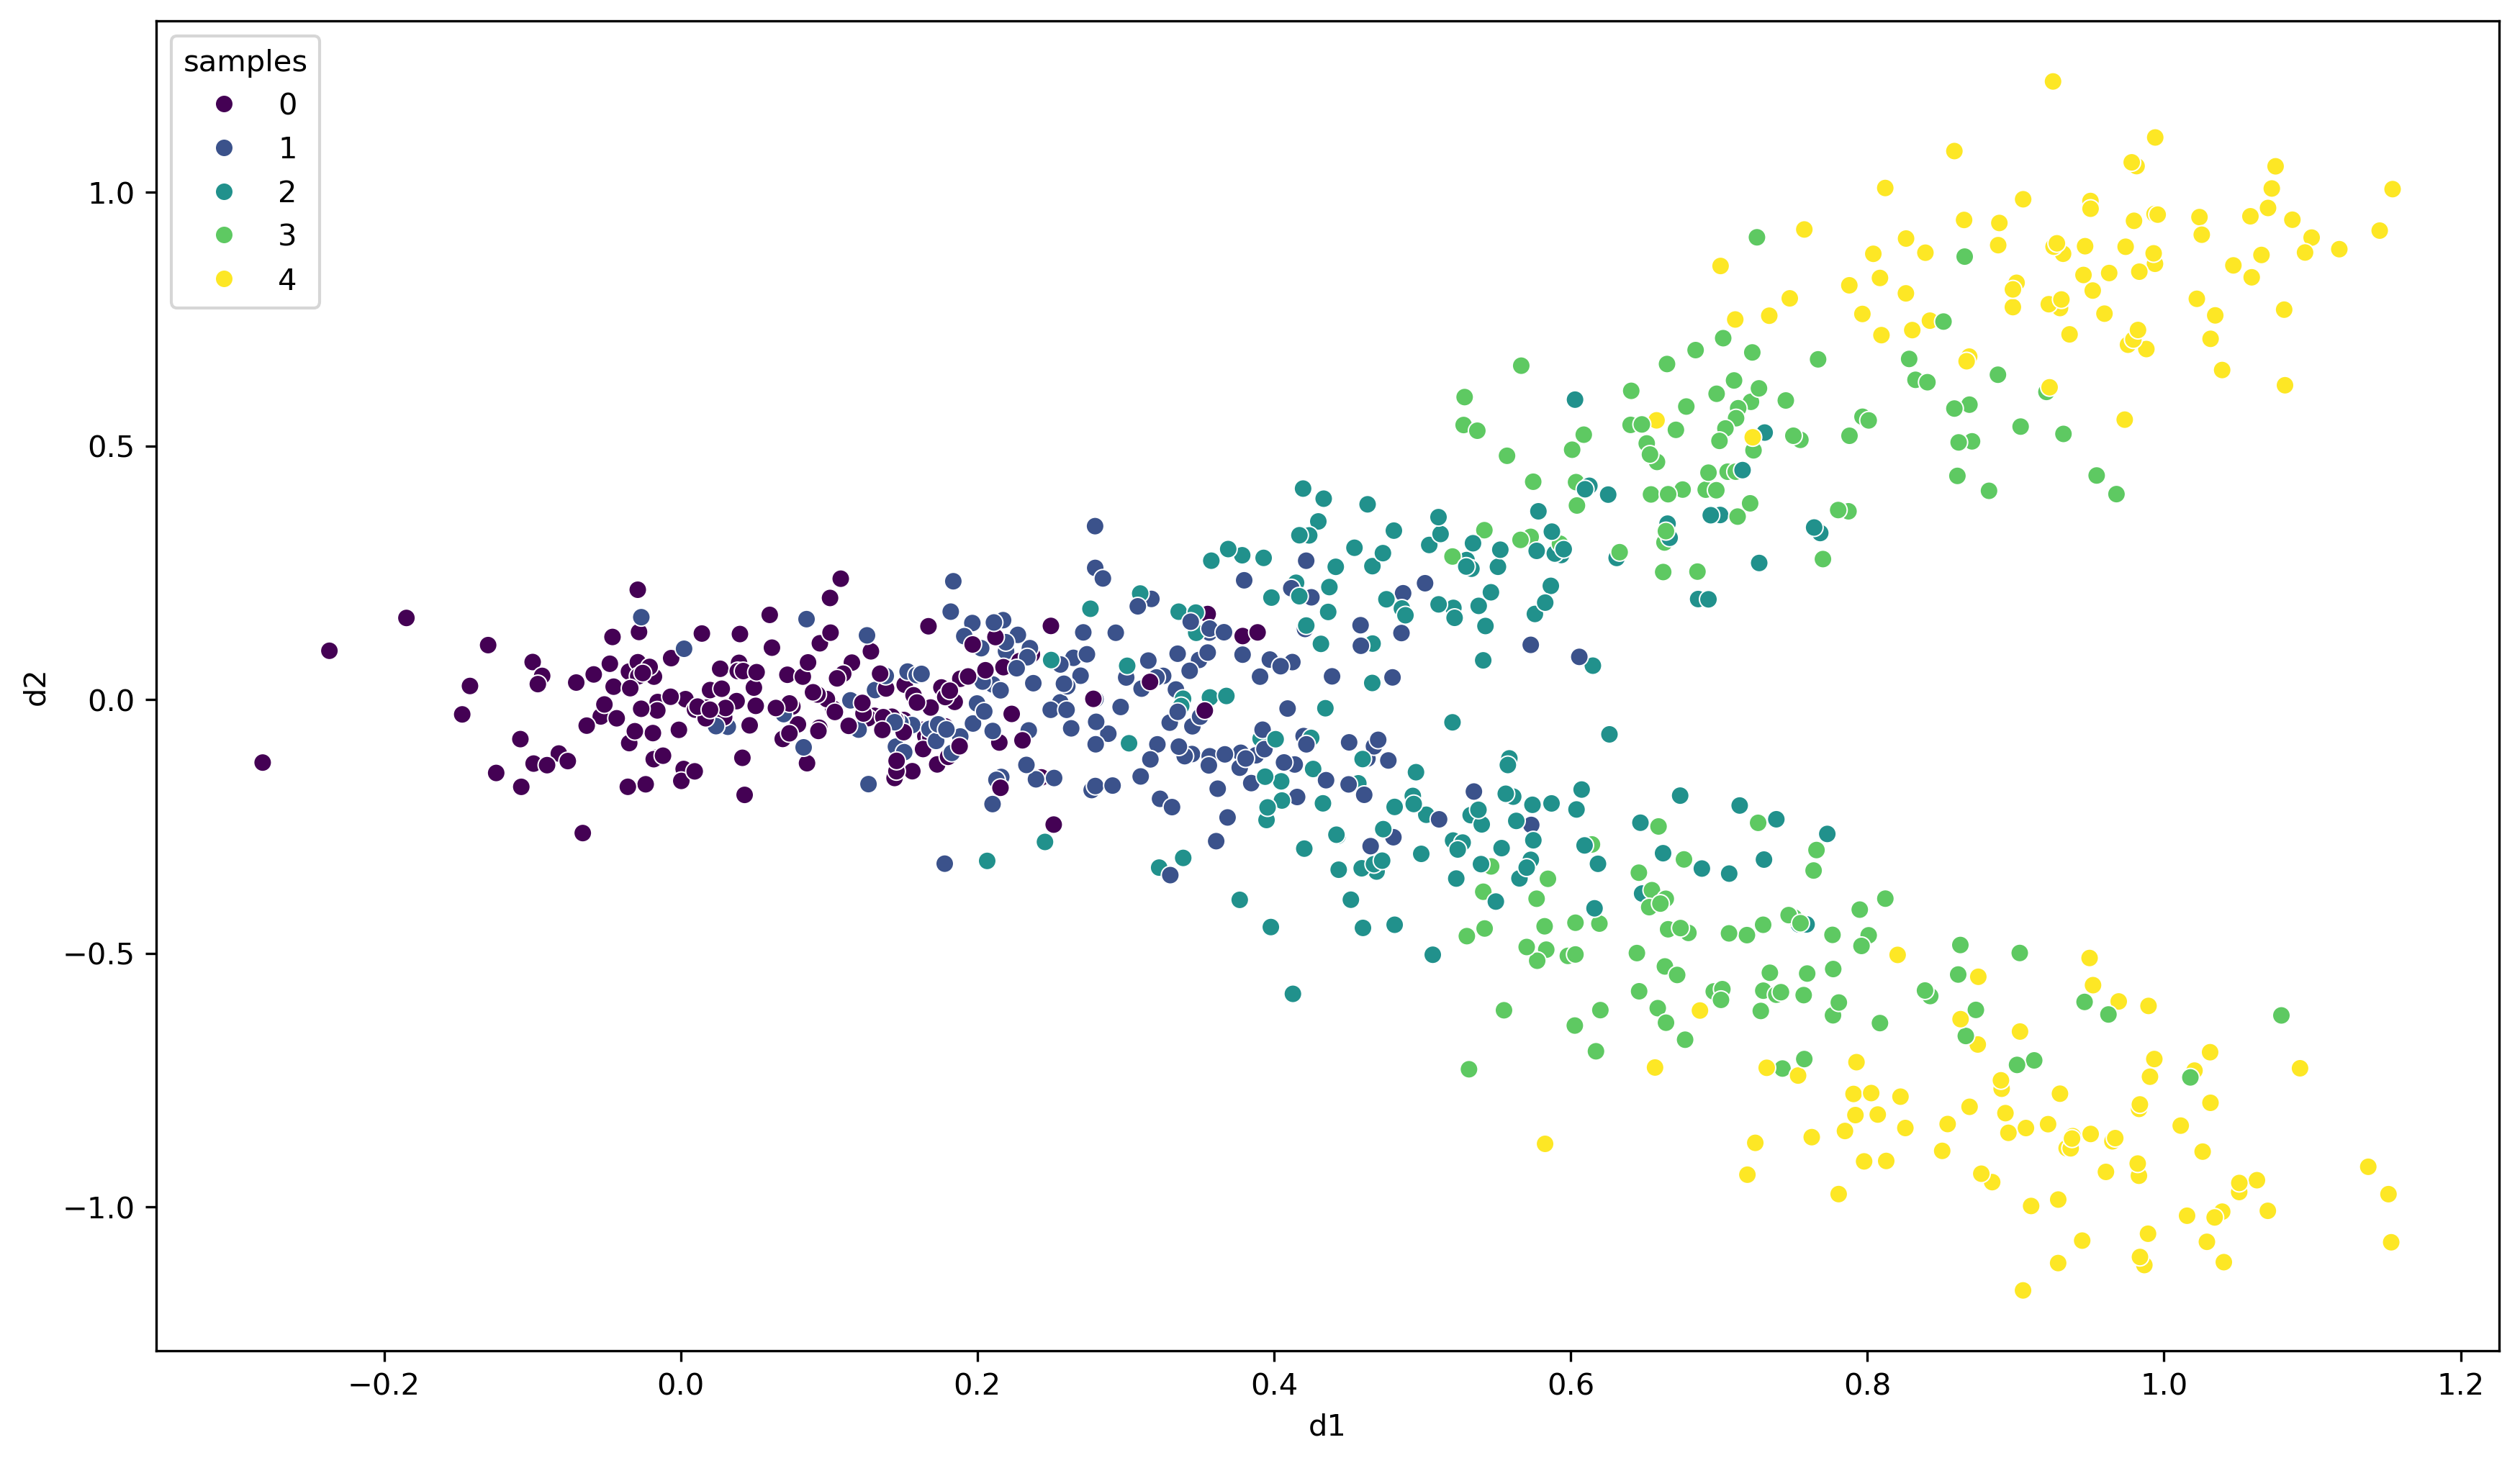

In [6]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

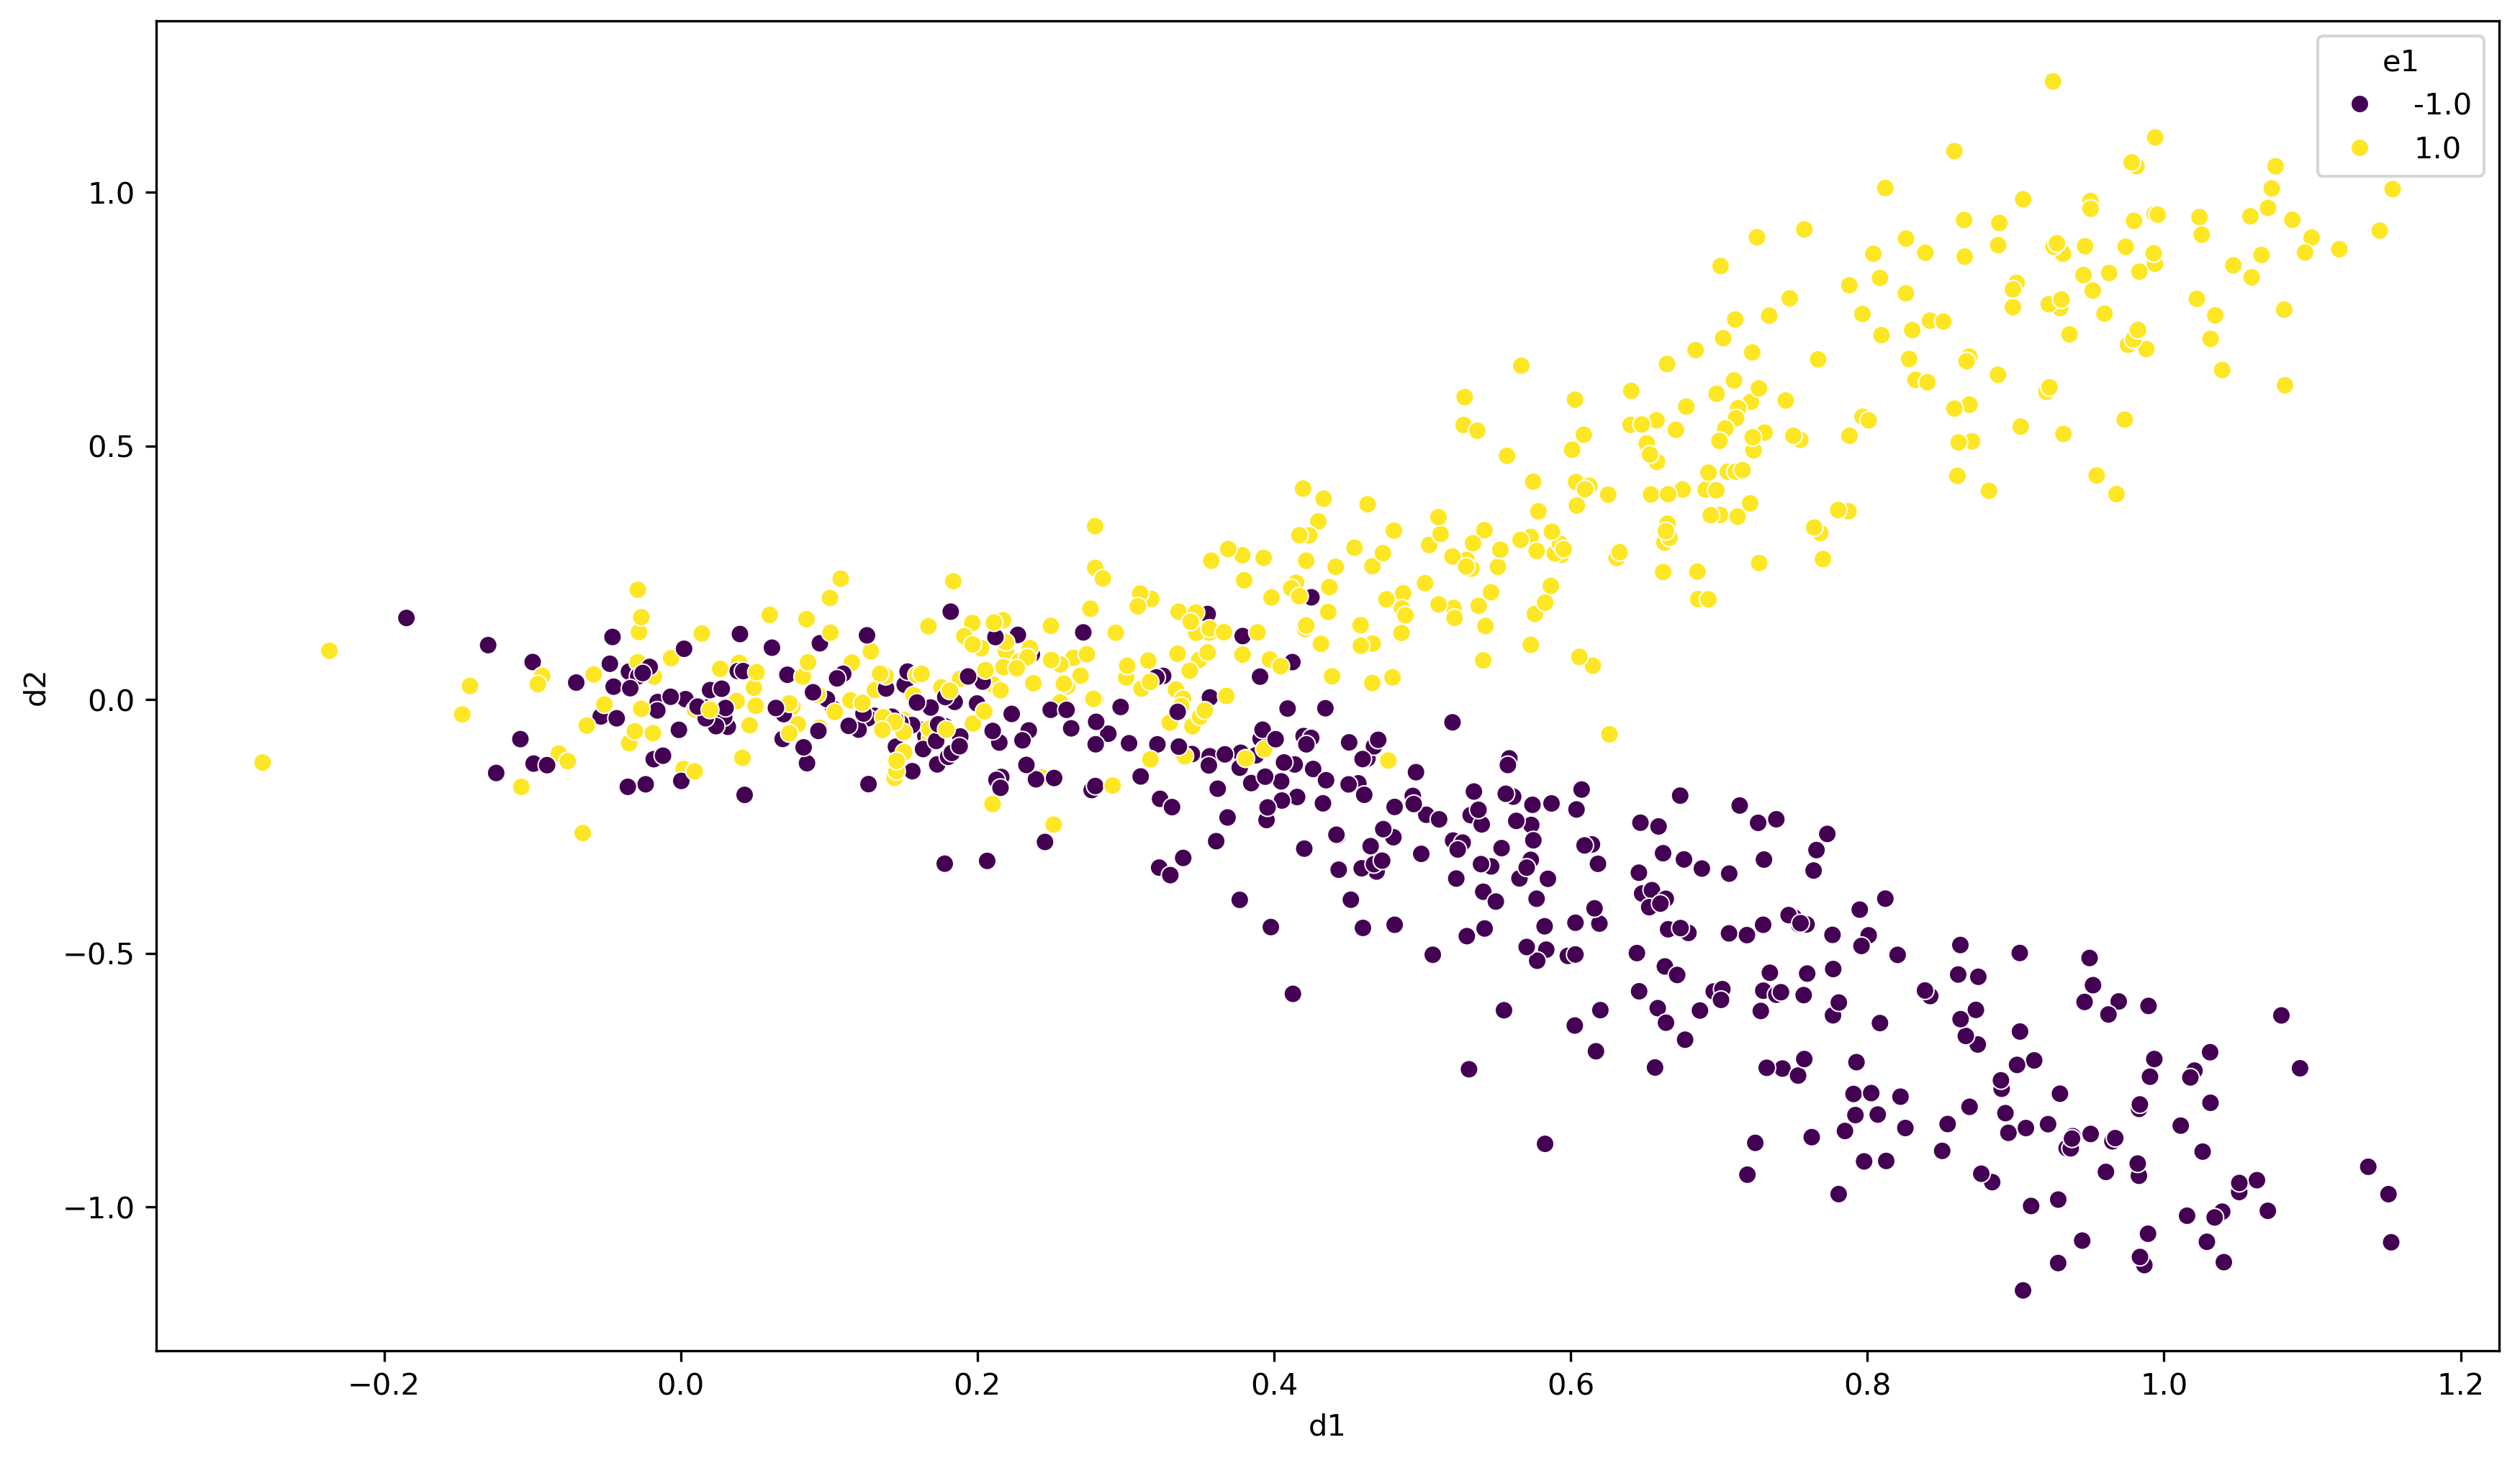

In [7]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

In [8]:
df_copy = df.copy()
df = df.drop(columns=['e1'])

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [9]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [10]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [11]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [12]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [13]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 35

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 

if recon:    
    model_features = gae_embedded_dim

# model = make_model(
#     model_features, layers, which='sde', method='euler',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

# model = make_model(
#     model_features, layers, which='sde', method='reversible_heun', sde_type='stratonovich', adjoint_method='adjoint_reversible_heun',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )

model = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)
model2 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)


In [14]:
model.norm

[]

In [15]:
# Basically "batch size"
# sample_size=(60, )
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name, covariance_lambda=100.0, detach_dist_for_plan=False)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [16]:
opts = {
    'phate_dims': 2,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [17]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [18]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [19]:
criterion2 = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=False)
start_time = time.time()
optimizer2 = torch.optim.AdamW(model2.parameters())

local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model2, df=df, groups=groups, optimizer=optimizer2, 
    criterion=criterion2, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

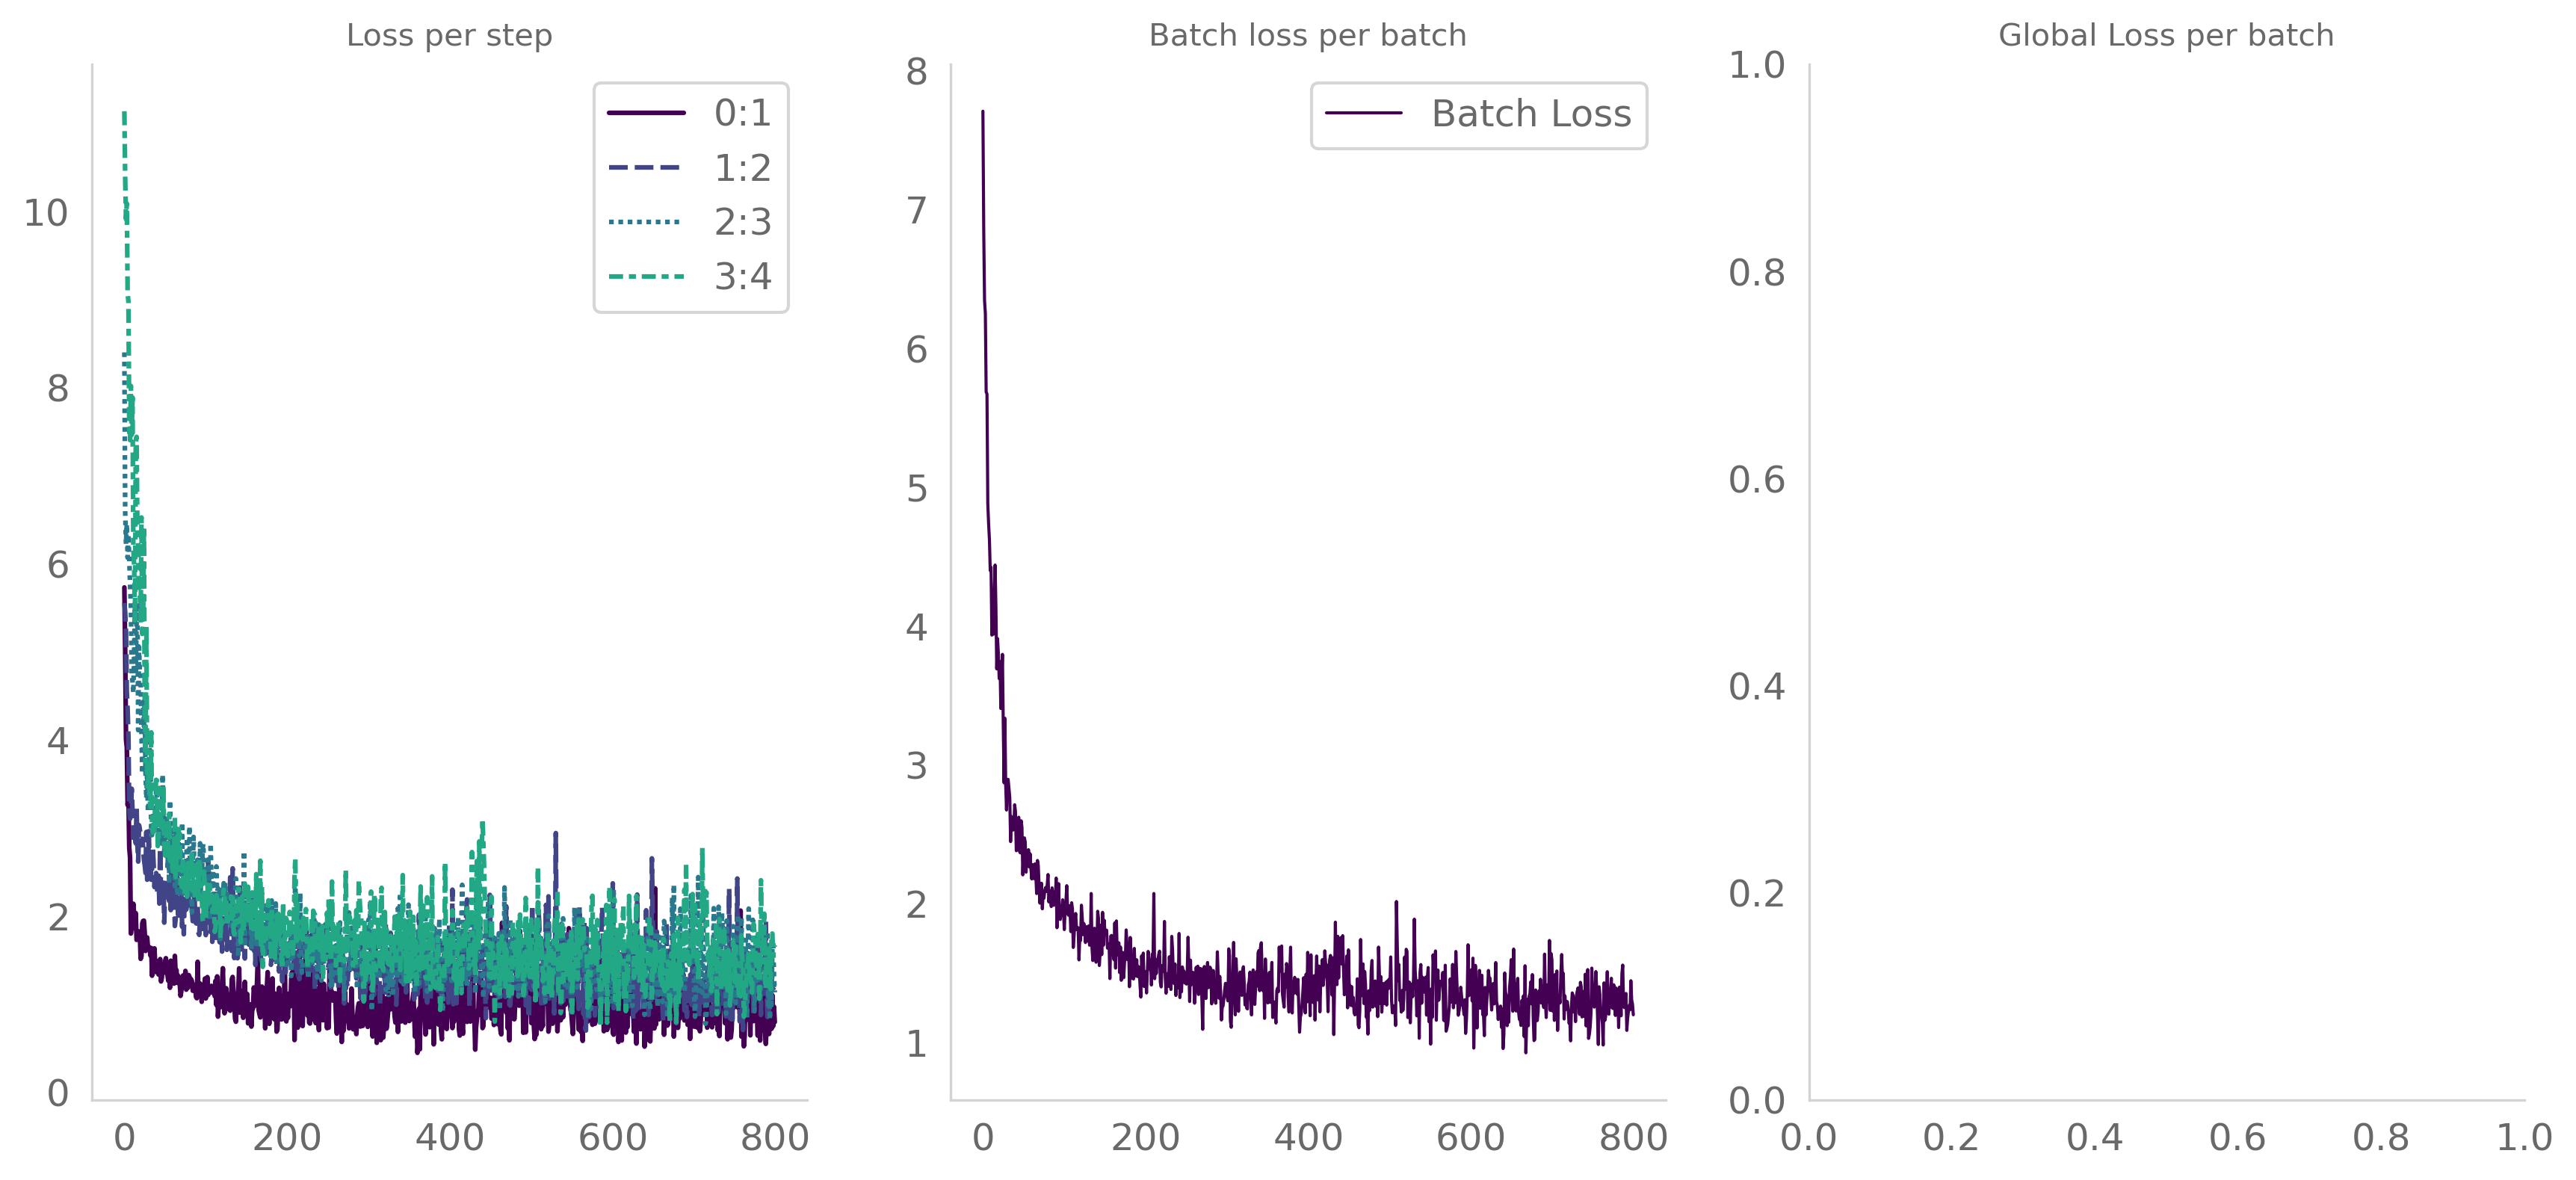

In [20]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [21]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


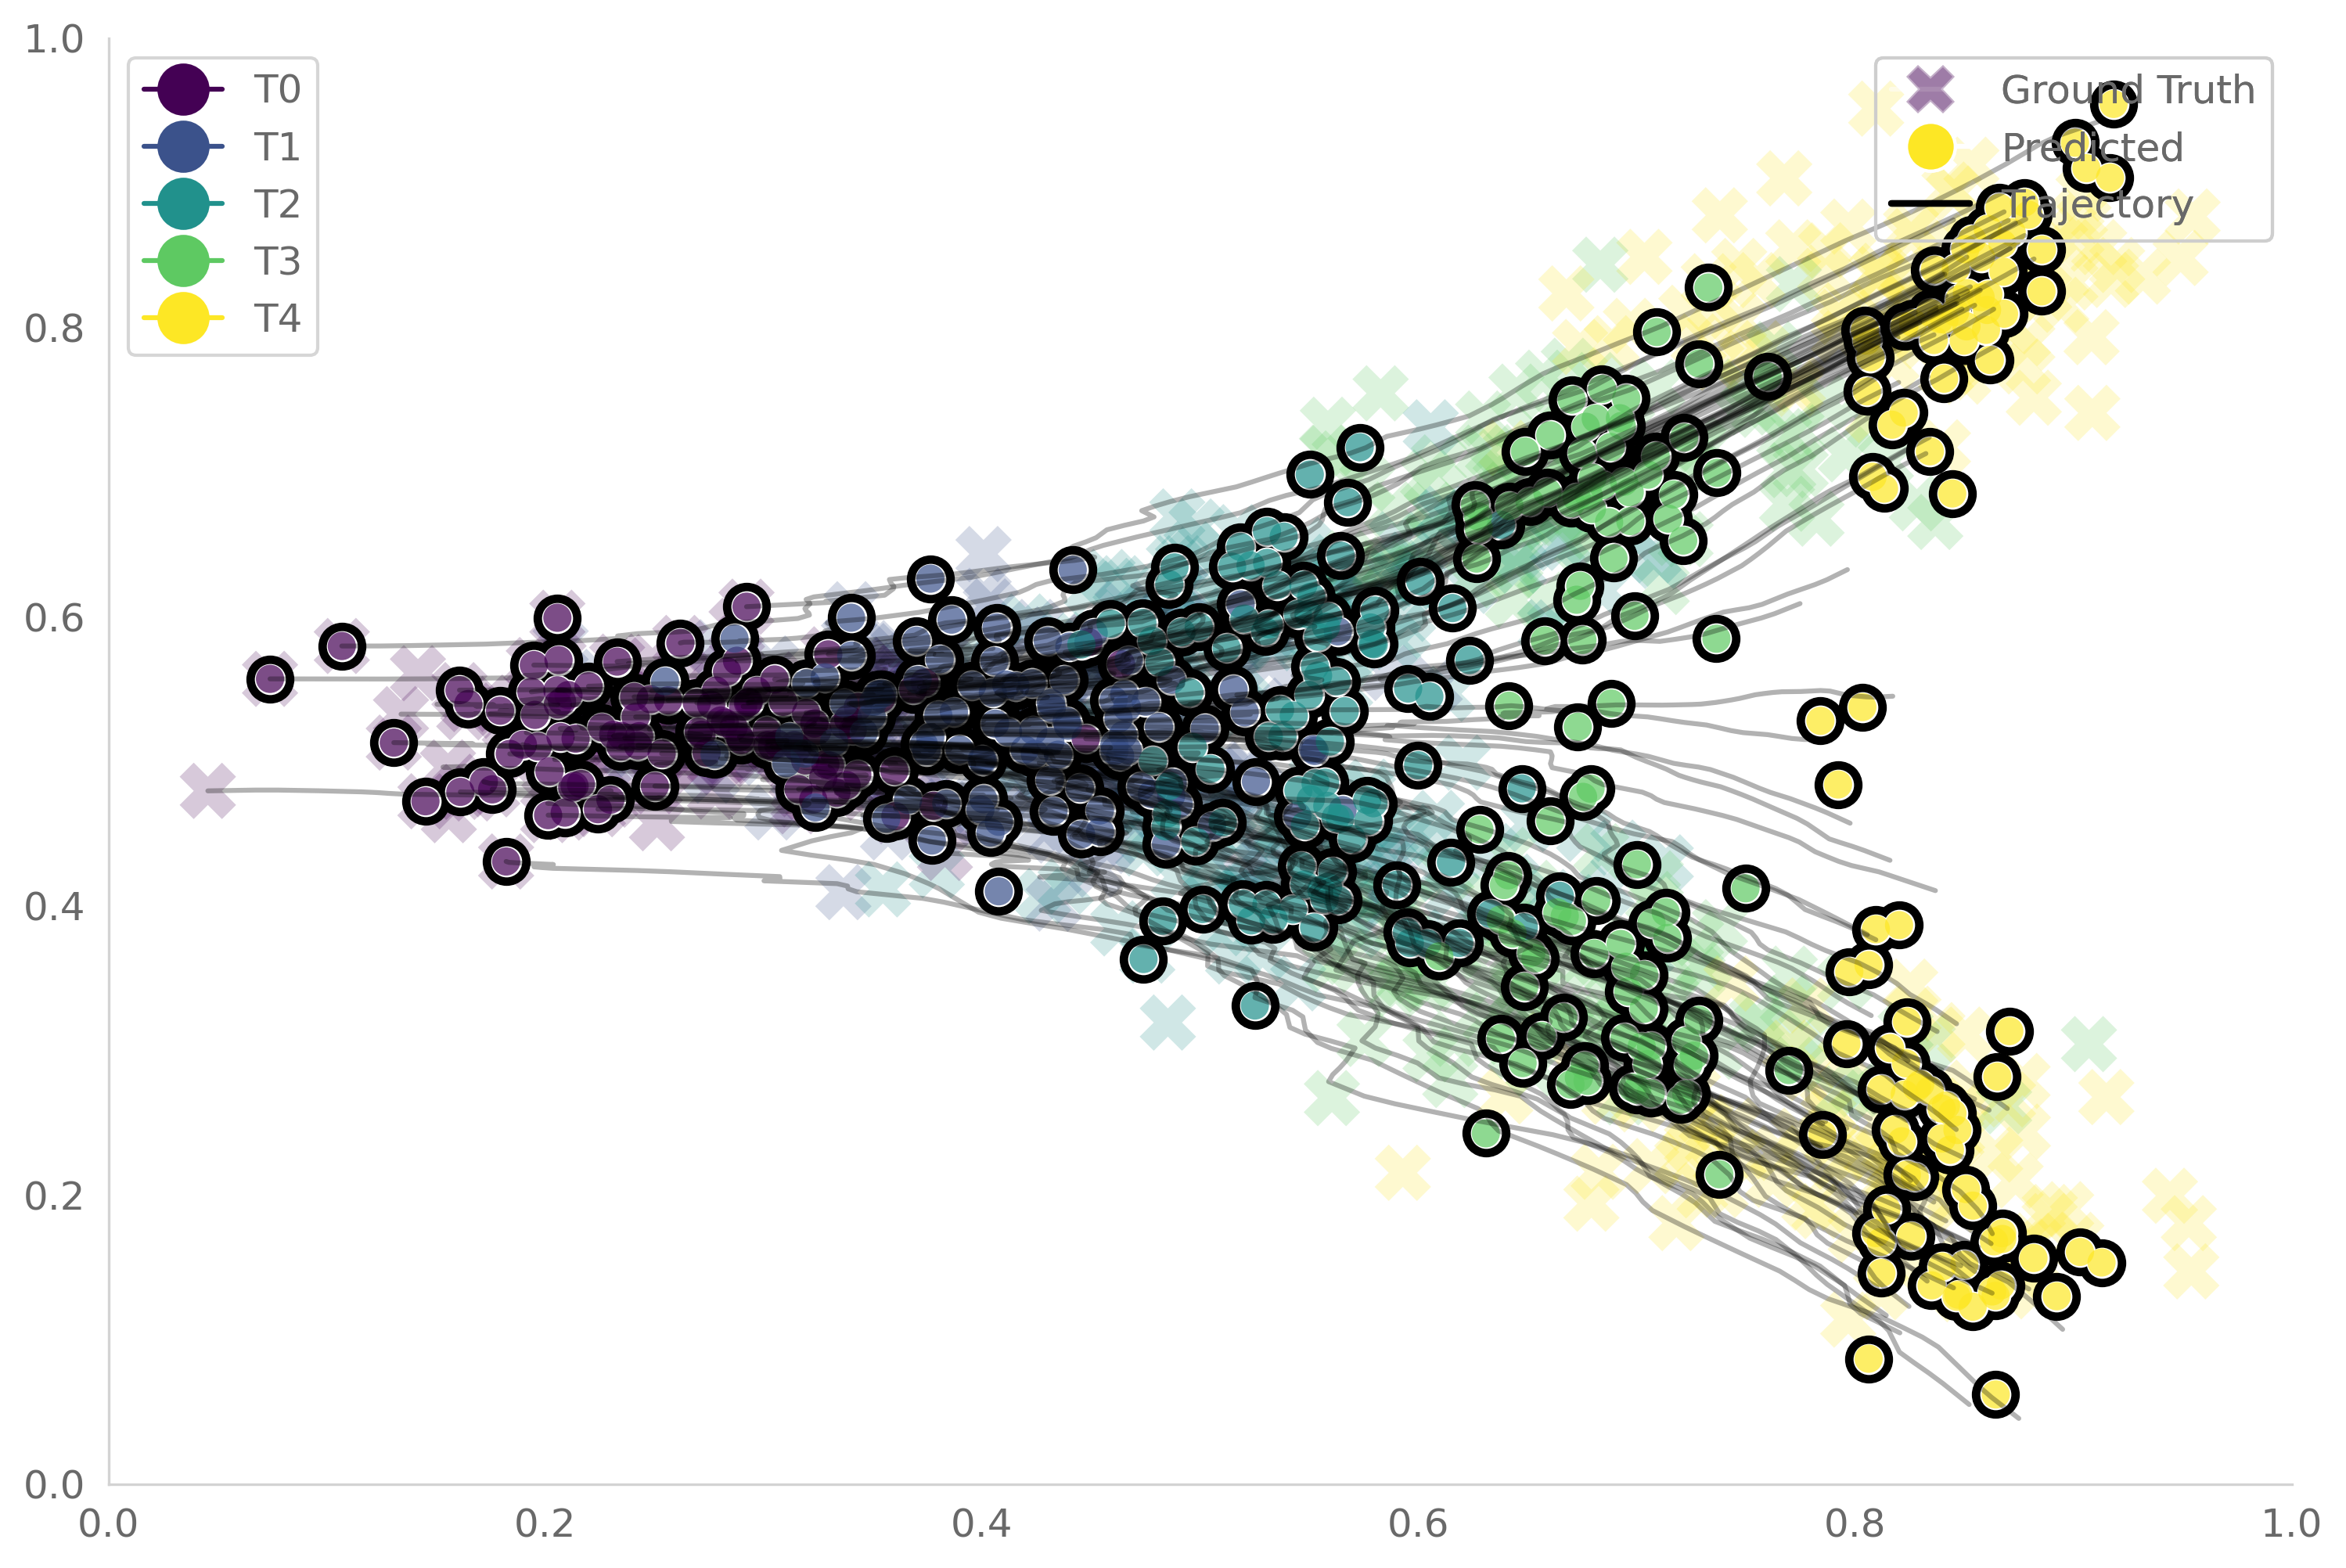

In [22]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

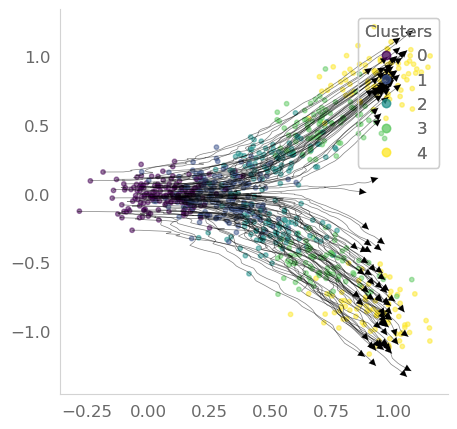

In [23]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

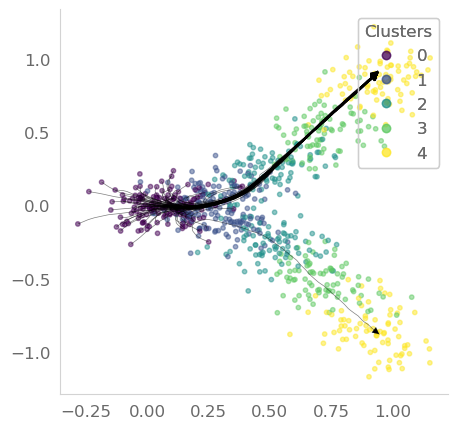

In [24]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model2(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

+-----------------------------------+-------------------+-----------+
| Model                             |   Covariance Loss |   OT Loss |
+===================================+===================+===========+
| Model 1 (trained with covariance) |           2.49601 | 0.0363495 |
+-----------------------------------+-------------------+-----------+
| Model 2 (trained with OT)         |          58.4983  | 4.67641   |
+-----------------------------------+-------------------+-----------+


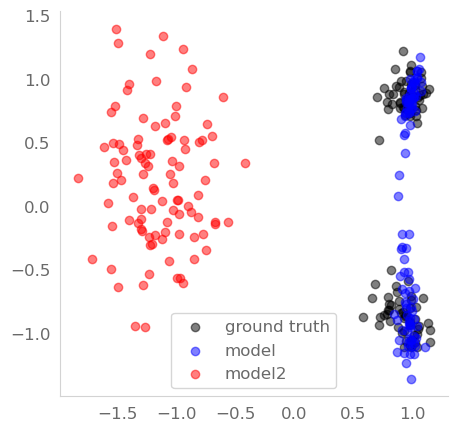

In [51]:
t0 = 0
t1 = 4
data_t0 = sample(
    df, t0, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, t1, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time1 = torch.tensor([t0,t1], dtype=data_t0.dtype, device=data_t0.device)
with torch.no_grad():
    x_traj1 = model(data_t0, sample_time1, return_whole_sequence=False)
    x_traj2 = model2(data_t0, sample_time1, return_whole_sequence=False)

loss1_cov = criterion(x_traj1, data_t1)
loss2_cov = criterion(x_traj2, data_t1)
loss1_ot = criterion2(x_traj1, data_t1)
loss2_ot = criterion2(x_traj2, data_t1)

from tabulate import tabulate
data = [
    ["Model 1 (trained with covariance)", loss1_cov.item(), loss1_ot.item()],
    ["Model 2 (trained with OT)", loss2_cov.item(), loss2_ot.item()]
]
headers = ["Model", "Covariance Loss", "OT Loss"]
print(tabulate(data, headers=headers, tablefmt="grid"))

plt.figure(figsize=(5, 5))
plt.scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
plt.scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model')
plt.scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
plt.legend()


In [52]:
x_traj[-1, ...]


tensor([[ 0.9404,  0.9144],
        [ 0.9416,  0.9041],
        [ 0.9413,  0.9072],
        [ 0.9403,  0.8995],
        [ 0.9407,  0.9065],
        [ 0.9409,  0.9047],
        [ 0.9410,  0.9009],
        [ 0.9405,  0.8986],
        [ 0.9417,  0.9094],
        [ 0.9416,  0.9083],
        [ 0.9406,  0.9092],
        [ 0.9404,  0.9027],
        [ 0.9410,  0.9034],
        [ 0.9412,  0.9077],
        [ 0.9411,  0.9077],
        [ 0.9406,  0.9041],
        [ 0.9390,  0.9072],
        [ 0.9398,  0.9044],
        [ 0.9403,  0.8984],
        [ 0.9416,  0.9096],
        [ 0.9434,  0.9071],
        [ 0.9406,  0.9013],
        [ 0.9401,  0.8992],
        [ 0.9411,  0.9035],
        [ 0.9410,  0.8969],
        [ 0.9421,  0.9028],
        [ 0.9403,  0.9055],
        [ 0.9402,  0.8993],
        [ 0.9398,  0.9037],
        [ 0.9410,  0.9126],
        [ 0.9411,  0.9121],
        [ 0.9410,  0.9140],
        [ 0.9414,  0.9007],
        [ 0.9407,  0.9115],
        [ 0.9409,  0.9016],
        [ 0.9397,  0

In [53]:
model.func(sample_time[-1], data_t0)

tensor([[ 0.6268, -0.1092],
        [ 0.5952, -0.4416],
        [ 0.6933, -0.1847],
        [ 0.5101, -0.0028],
        [ 0.5412,  0.0504],
        [ 0.5530, -0.3238],
        [ 0.5587, -0.3529],
        [ 0.5457,  0.1866],
        [ 0.3969, -0.2478],
        [ 0.5184, -0.0663],
        [ 0.5296, -0.2994],
        [ 0.3033, -0.2336],
        [ 0.2571, -0.4660],
        [ 0.4918, -0.1202],
        [ 0.3278,  0.0394],
        [ 0.4825, -0.1603],
        [ 0.5507, -0.3636],
        [ 0.5801, -0.1216],
        [ 0.3963,  0.0476],
        [ 0.6852, -0.0616],
        [ 0.3266, -0.2028],
        [ 0.4177, -0.4126],
        [ 0.4380, -0.3662],
        [ 0.3321, -0.3564],
        [ 0.6017, -0.0773],
        [ 0.4762, -0.2924],
        [ 0.5043, -0.0929],
        [ 0.7210, -0.3120],
        [ 0.4856, -0.1305],
        [ 0.4657, -0.1594],
        [ 0.5989, -0.3394],
        [ 0.6292, -0.2045],
        [ 0.4266, -0.1517],
        [ 0.4746, -0.0748],
        [ 0.3819, -0.2219],
        [ 0.5273, -0

In [54]:
model.gunc(sample_time[-1], data_t0)

tensor([[ 0.1820, -0.0958],
        [-0.1187, -0.0935],
        [-0.1101, -0.0439],
        [-0.0541, -0.0187],
        [-0.0195, -0.1735],
        [ 0.1485,  0.0589],
        [-0.0717,  0.0376],
        [-0.0622, -0.0520],
        [-0.0067,  0.0658],
        [-0.0973,  0.0954],
        [-0.1003,  0.0269],
        [-0.1092,  0.0295],
        [ 0.0880, -0.0173],
        [-0.1194, -0.1236],
        [ 0.0688, -0.1013],
        [-0.0950,  0.0209],
        [-0.0313, -0.1213],
        [-0.0825,  0.0688],
        [ 0.0307, -0.1590],
        [-0.0821, -0.0964],
        [ 0.0439, -0.1154],
        [ 0.1117, -0.0682],
        [ 0.1563,  0.0234],
        [-0.0311,  0.0369],
        [ 0.0535, -0.0090],
        [-0.0049, -0.0214],
        [ 0.0119,  0.0377],
        [ 0.1274, -0.0903],
        [ 0.1869, -0.0005],
        [-0.0507,  0.0071],
        [ 0.0119, -0.1767],
        [ 0.0606, -0.0725],
        [-0.2564,  0.1222],
        [-0.0028,  0.0491],
        [ 0.1331, -0.1454],
        [ 0.1476, -0

In [55]:
# saving the trajectories and generated points
# np.save(os.path.join(exp_dir,'trajectories_petal.npy'),trajectories)
# np.save(os.path.join(exp_dir,'generated_petal.npy'),generated)

In [56]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [57]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [58]:
RES_DIR

'/Users/xingzhi/Research/MIOFlow_conditional/results'

In [59]:
exp_dir

'/Users/xingzhi/Research/MIOFlow_conditional/results/test'

In [60]:
# np.random.seed(32)
# groups = sorted(df['samples'].unique())
# sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
# from MIOFlow.utils import sample
# data_t0 = sample(
#     df, np.min(groups), size=(n_points, ), 
#     replace=False, to_torch=True, use_cuda=use_cuda
# )
# sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

# with torch.no_grad():
#     x_traj = model(data_t0, sample_time, return_whole_sequence=True)

# savepath = './'
# np.save(os.path.join(savepath, 'trajectories.npy'), x_traj)

In [61]:
trajectories.shape

(100, 100, 2)

In [62]:
model2 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)

In [63]:
model2.gunc.seq[0].weight.data

tensor([[-3.9607e-01,  2.3553e-01, -2.0759e-01,  1.4412e-01,  3.1889e-01],
        [-5.0540e-02,  1.5128e-01, -2.0698e-02,  2.3638e-01,  4.3304e-01],
        [-2.5375e-02, -3.7426e-01, -1.1650e-01,  7.7442e-03, -7.0904e-02],
        [-2.6317e-01, -1.8166e-01, -2.0270e-02,  3.5434e-01,  2.0444e-01],
        [ 4.0309e-01, -3.1250e-01, -1.6693e-02, -2.0020e-01,  4.3350e-01],
        [-2.3158e-01,  2.0284e-01,  3.8118e-04, -2.3214e-01,  3.3156e-02],
        [ 8.6481e-03, -1.3687e-01,  2.3876e-02, -1.7266e-01, -3.1943e-01],
        [-2.8190e-01,  8.1795e-02, -1.2394e-01, -4.0198e-01, -2.6184e-01],
        [-3.5608e-02, -4.2761e-01,  1.7961e-01, -3.5491e-01, -2.0679e-02],
        [ 4.3875e-01,  2.2478e-01,  3.4691e-01,  2.0042e-01,  1.3204e-01],
        [-1.1926e-01,  2.7535e-01,  3.1999e-01, -3.8353e-01, -8.3788e-02],
        [-3.2147e-01,  2.9018e-01, -1.6362e-01, -2.9532e-01,  2.5310e-01],
        [ 1.1806e-01,  4.0686e-01,  2.1453e-01,  2.9201e-01, -3.0445e-01],
        [ 3.6787e-01, -3.